In [1]:
import duckdb
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.signal import savgol_filter

duckdb.sql("""
CREATE TABLE geos AS 
SELECT * FROM 
(
SELECT NORAD_CAT_ID, count(*) as count
FROM 'database/twoline.parquet'
WHERE abs(N - 1.0) < 0.01
AND ECC < 0.01
AND INC < 0.1
GROUP BY NORAD_CAT_ID
ORDER BY NORAD_CAT_ID
)
WHERE count > 100
WHERE 
"""
)
all_geo_tles_by_norad = duckdb.sql("""
SELECT EPOCH, all_geos.NORAD_CAT_ID, INC FROM 'database/twoline.parquet' AS all_geos
JOIN geos ON (all_geos.NORAD_CAT_ID = geos.NORAD_CAT_ID)
ORDER BY all_geos.NORAD_CAT_ID, EPOCH
""").pl().partition_by('NORAD_CAT_ID')

In [100]:
ftimes = []

for i,x in enumerate(all_geo_tles_by_norad):
    xf = (x
    .select('EPOCH', 'INC')
    .with_columns(
        pl.col('EPOCH').dt.round(f'5d').alias('EPOCH'),
        )
    .group_by('EPOCH')
    .agg(pl.col('INC').median())
    .sort('EPOCH')
    )

    first_considered_date = xf.filter(pl.col("INC") < 0.25)['EPOCH'][0]

    # xf = xf.with_columns(
    #     rolling_inc=pl.col('INC').rolling_median(window_size=2, center=True)
    # )
    xf = xf.with_columns(
        local_min=pl.col('INC').peak_min(),
    ).slice(1,xf.height-1)

    xf = (
        xf
        .with_columns(
        pl.when(pl.col('local_min'))
        .then(pl.col('EPOCH'))
        .otherwise(None)
        .alias('LAST_LOCAL_MIN_EPOCH')
        )
        .fill_null(strategy='forward')
        .with_columns(
            pl.col('LAST_LOCAL_MIN_EPOCH').diff(n=1).alias('TIME_SINCE_PREV_MIN')
        )
        .drop_nulls()
        .filter(
            pl.col('TIME_SINCE_PREV_MIN') > pl.duration(days=0),
            pl.col('TIME_SINCE_PREV_MIN') < pl.duration(days=720),
            pl.col('INC') < 0.25,
        )
    )

    
    if xf.height:
        candidate_ftime = xf.tail(1)['EPOCH'].to_list()[0]

        xf_last_year = x.filter(
            pl.col('EPOCH') > candidate_ftime - pl.duration(days=365),
            pl.col('EPOCH') > first_considered_date)
        inc_most_recent = xf_last_year['INC'][-1]
        inc_one_year_before = xf_last_year['INC'][0]

        if inc_most_recent > 1.0 and inc_one_year_before < 1.0:
            ftimes.append(candidate_ftime)
        else:
            ftimes.append(None)
    
        # if x['NORAD_CAT_ID'][0] == 6796:
        #     print(xf)
        #     print(candidate_ftime)
        #     print(inc_most_recent, inc_one_year_before)
        #     print(ftimes)
        #     endd
    else:
        ftimes.append(None)
    

res = duckdb.sql("SELECT * FROM geos").pl().with_columns(pl.Series(name='deactivate_times', values=ftimes))
res_sorted = res.sort('deactivate_times').drop_nulls()
res_sorted

NORAD_CAT_ID,count,deactivate_times
u32,i64,datetime[μs]
3029,108,1969-10-13 00:00:00
6278,276,1980-09-20 00:00:00
5709,131,1981-02-07 00:00:00
10953,297,1981-04-08 00:00:00
6796,112,1982-05-28 00:00:00
…,…,…
31307,7785,2023-05-08 00:00:00
33459,7310,2023-05-18 00:00:00
29273,8252,2023-05-23 00:00:00


464
42763 decayed on 2021-02-17 00:00:00


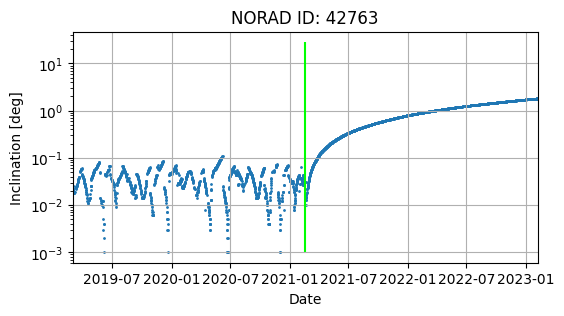

In [128]:
decayed_dfs = [x.join(res_sorted, on='NORAD_CAT_ID') for x in all_geo_tles_by_norad if x['NORAD_CAT_ID'][0] in res_sorted['NORAD_CAT_ID'].to_list()]
i = -3
x = decayed_dfs[i]
ftime = x['deactivate_times'][0]

print(len(decayed_dfs))
print(f"{x['NORAD_CAT_ID'][0]} decayed on {x['deactivate_times'][0]}")
inc = x['INC'].to_numpy()
inc = x['INC'].to_numpy()
epoch = np.array(x['EPOCH'].to_list())

plt.figure(figsize=(6,3))
plt.scatter(epoch, inc, label="Inclination", s=1)
plt.vlines(ftime, 1e-3, plt.ylim()[1], color='lime', label='Decay epoch')
plt.xlabel("Date")
plt.ylabel("Inclination [deg]")
plt.grid()
plt.title(f"NORAD ID: {x['NORAD_CAT_ID'][0]}")
if ftime is not None:
    plt.xlim(ftime-datetime.timedelta(days=720), ftime+datetime.timedelta(days=720))
    plt.yscale('log')